<a href="https://colab.research.google.com/github/ShreyaMandot/Topic-Modelling-Using-LDA-Top2Vec-BERTopic/blob/main/LDA_BOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os.path
import re
import spacy
import pandas as pd
from gensim import corpora
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pprint
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from pprint import pprint

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df=pd.read_csv('/content/Clean_Tweets.csv')
tweets_df=df.loc[:,['new_text']]
#tweets_df.info()
tweets_df['new_text']= df['new_text'].str.lower()

In [ ]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', str(sent))  # remove emails
        sent = re.sub('\s+', ' ', str(sent))  # remove newline chars
        sent = re.sub("\'", "", str(sent))  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)

In [ ]:
data = tweets_df.new_text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])


[['days', 'into', 'escitalopram', 'withdrawal', 'and', 'feel', 'so', 'sick']]


In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['day', 'withdrawal', 'feel', 'sick']]


In [ ]:
dictionary = gensim.corpora.Dictionary(data_lemmatized)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in data_lemmatized]

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics=65,
                                       id2word=dictionary,
                                       random_state=100,
                                        chunksize=100,
                                         passes=2,
                                        per_word_topics=True)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.432*"show" + 0.225*"let" + 0.079*"thank" + 0.052*"story" + 0.052*"recently" + 0.052*"end" + 0.034*"second" + 0.025*"continue" + 0.022*"kid" + 0.012*"awesome"
Topic: 1 
Words: 0.330*"bad" + 0.237*"never" + 0.134*"ago" + 0.087*"generic" + 0.070*"dog" + 0.037*"sick" + 0.031*"visit" + 0.031*"step" + 0.020*"sad" + 0.004*"nauseous"
Topic: 2 
Words: 0.155*"medical" + 0.138*"therapy" + 0.135*"disorder" + 0.087*"case" + 0.064*"major" + 0.059*"report" + 0.056*"drop" + 0.051*"soon" + 0.049*"depressive" + 0.044*"result"
Topic: 3 
Words: 0.336*"much" + 0.224*"research" + 0.073*"interesting" + 0.061*"suck" + 0.054*"team" + 0.051*"amount" + 0.041*"wall" + 0.036*"trouble" + 0.034*"affect" + 0.022*"damage"
Topic: 4 
Words: 0.341*"start" + 0.146*"last" + 0.130*"night" + 0.092*"meat" + 0.060*"hospital" + 0.057*"currently" + 0.050*"likely" + 0.039*"mood" + 0.020*"important" + 0.014*"game"
Topic: 5 
Words: 0.492*"bupropion" + 0.101*"medication" + 0.081*"issue" + 0.074*"cause" + 0.047*"pa

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=bow_corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,48.0,0.6031,"day, sleep, hour, less, withdrawal, feel, avoi...","[day, withdrawal, feel, sick]"
1,1,2.0,0.4031,"medical, therapy, disorder, case, major, repor...","[go, convince, change, soon]"
2,2,10.0,0.5038,"autismcapital, link, wait, kill, office, fast,...","[wait, escitalopram, poise, kill]"
3,3,11.0,0.3385,"amp, ask, world, hear, symptom, believe, child...","[exam, amp, escitalopram]"
4,4,0.0,0.4559,"show, let, thank, story, recently, end, second...","[thank, balanced, arm, randomise, escitalopram..."
5,5,54.0,0.6684,"treatment, spravato, finally, esketamine, lead...","[effect, escitalopram, treatment, chronic, mil..."
6,6,49.0,0.4462,"paxil, zoloft, inhibitor, shit, different, for...","[nephrosafe, escitalopram, sertraline, safe, t..."
7,7,49.0,0.2519,"paxil, zoloft, inhibitor, shit, different, for...","[never, really, shit, m, thing, take, obviously]"
8,8,7.0,0.3385,"prescribe, long, man, do, figure, article, sin...","[fix, lexapro]"
9,9,11.0,0.2239,"amp, ask, world, hear, symptom, believe, child...","[m, bipolar, amp, lithium, amp, escitalopram, ..."


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -7.469071672487258

Coherence Score:  0.5167692712376519


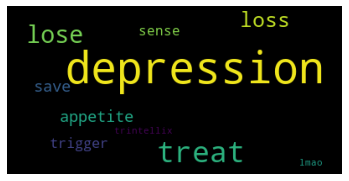

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(dict(lda_model.show_topic(28, topn=10)))

# Display the wordcloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

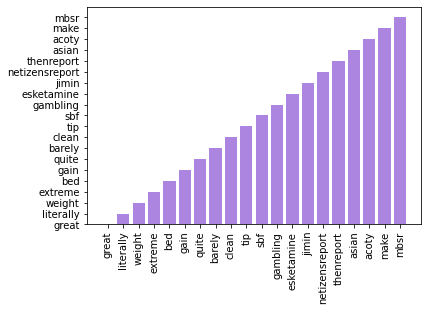

In [ ]:
import numpy as np
topic_0_words = lda_model.show_topic(topicid=63, topn=20)
topic_0_words = [word for word, prob in topic_0_words]

# Create the bar chart
plt.bar(range(len(topic_0_words)), topic_0_words,color=np.random.rand(3,) )
plt.xticks(range(len(topic_0_words)), topic_0_words, rotation='vertical')
plt.show()

In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis=pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary, mds="mmds", R=20 )
vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyLDAvis-3.3.1.tar.gz (1.7 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached sklearn-0.0.post1.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=a43782ad147c8ef97ce8fe5213443fa36f31371e94bb54d2b22d6c64a05614cb
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=322aca2a72fe88953d108838f74608354baee0401eda774d2098a5616483aef9
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
58    -0.308124 -0.443194       1        1  3.063144
5     -0.422680  0.338746       2        1  2.834421
14     0.115992  0.385931       3        1  2.762982
12    -0.384894  0.142823       4        1  2.717875
48    -0.521736  0.033469       5        1  2.648409
...         ...       ...     ...      ...       ...
0      0.415832 -0.056357      61        1  1.010220
37     0.502172  0.049412      62        1  0.974757
63     0.233847  0.422978      63        1  0.961381
9      0.406764 -0.299363      64        1  0.959883
44     0.154183 -0.045317      65        1  0.869270

[65 rows x 5 columns], topic_info=            Term         Freq        Total Category  logprob  loglift
423        study  1173.000000  1173.000000  Default  20.0000  20.0000
35          take  1026.000000  1026.000000  Default  19.0000  19.0000
30             m   929.000000   929.000000  Default  18.0000  18.0000
613    bupropion  1000.000000  1000.000000  Default  17.0000  17.0000
83          help   876.000000   876.000000  Default  16.0000  16.0000
..           ...          ...          ...      ...      ...      ...
898     gambling     0.019622    64.575291  Topic65 -10.3656  -3.3537
954  mindfulness     0.019588    28.471885  Topic65 -10.3673  -2.5365
951     spravato     0.019588   271.598280  Topic65 -10.3673  -4.7919
952   esketamine     0.019588   442.988150  Topic65 -10.3673  -5.2811
959      program     0.019587    15.587712  Topic65 -10.3674  -1.9341

[1653 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
484      38  0.955111     abilify
398      58  0.913089     ability
298      31  0.978380        able
930      45  0.920696    absolute
507      22  0.982169  absolutely
...     ...       ...         ...
596      38  0.740979       young
907      41  0.952120          yr
655      19  0.929832         zap
540      14  0.994968      zoloft
54       50  0.656913      zombie

[960 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[59, 6, 15, 13, 49, 36, 23, 32, 61, 40, 51, 55, 62, 50, 47, 21, 5, 58, 43, 27, 46, 20, 60, 12, 2, 37, 26, 52, 16, 31, 17, 29, 3, 8, 54, 22, 63, 24, 56, 44, 9, 34, 14, 41, 57, 48, 42, 18, 19, 28, 4, 11, 30, 7, 35, 39, 33, 53, 65, 25, 1, 38, 64, 10, 45])